In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [4]:
file_path = 'market-price.csv'
bitcoin_df = pd.read_csv(file_path, names=['day', 'price'])

In [5]:
# 기본 정보 출력
print(bitcoin_df.shape)
print(bitcoin_df.info())
print(bitcoin_df.head())
bitcoin_df.tail()

(361, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 2 columns):
day      361 non-null object
price    361 non-null float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None
             day    price
0  2020.5.1 0:00  8628.77
1  2020.5.2 0:00  8824.66
2  2020.5.3 0:00  8973.82
3  2020.5.4 0:00  8903.95
4  2020.5.5 0:00  8885.93


,day,price
356,2021.4.22 0:00,53808.80
357,2021.4.23 0:00,51731.71
358,2021.4.24 0:00,51153.13
359,2021.4.25 0:00,50110.53
360,2021.4.26 0:00,49075.58


총 366개의 데이터를 가지고 있으며 day, price로 이루어진 시계열 데이터이다.

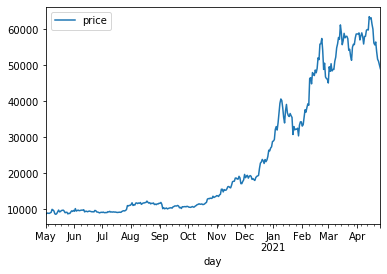

In [6]:
# day feature를 시계열로 변환
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

# day feature를 index화
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

# 일자별 비트코인 시세 시각화
bitcoin_df.plot()
plt.show()

## 1. ARIMA 분석

AR : 자기 자신의 과거 정보를 정보로 사용하는 개념, 현재의 상태는 이전의 상태를 참고해서 계산된다는 아이디어를 기반  
MA : 이전 항에서의 오차를 이용하여 현재 항의 상태를 추론하겠다  
+추세 변동의 경향성 반영

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [8]:
# ARIMA 모델 학습
model = ARIMA(bitcoin_df.price.values, order = (3,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  360
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -3055.298
Method:                       css-mle   S.D. of innovations           1165.704
Date:                Sat, 01 May 2021   AIC                           6124.597
Time:                        15:35:58   BIC                           6151.799
Sample:                             1   HQIC                          6135.413
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.3006     63.587      1.766      0.078     -12.328     236.929
ar.L1.D.y     -0.5420      0.053    -10.132      0.000      -0.647      -0.437
ar.L2.D.y     -0.9565      0.034    -28.168      0.0

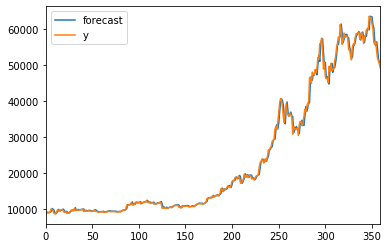

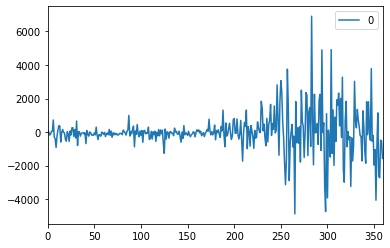

In [9]:
# 실제 데이터와 ARIMA 예측 데이터 시각화
fig = model_fit.plot_predict()

# 잔차의 변동 시각화
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

두 번째 그래프는 실제값과 예측값 사이의 오차 변동을 나타내는 그래프 (폭이 일정하다면 좋은 예측 모델 학습)  

모델의 평가를 위해 테스트 전용 데이터가 필요한데 5일 동안의 미래를 테스트 데이터로 사용 (불규칙적 시계열 예측은 먼 미래 예측이 큰 의미가 없다. 따라서 대략적인 경향 예측만을 수행하는 것이 일반적이다)

- 모델의 평가 과정  
    1. model_fit.forecast(steps=5)로 향후 5일 가격을 예측하여 pred_y로 정의
    2. 실제 향후 5일 가격을 test_y로 정의
    3. 모델이 예측한 상한값, 하한값을 pred_y_upper, pred_y_lower로 정의
    4. 정의한 모든 값을 비교하여 얼마나 맞는지 평가

In [10]:
# 5일 예측
forecast_data = model_fit.forecast(steps=5)

test_file_path = 'market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

In [11]:
pred_y = forecast_data[0].tolist()
test_y = bitcoin_test_df['y'].values
pred_y_lower = []
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

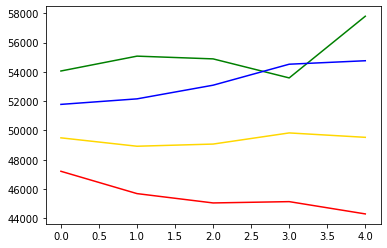

In [12]:
# 모델 그래프 시각화
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')
plt.plot(pred_y_lower, color='red')
plt.plot(pred_y_upper, color='blue')

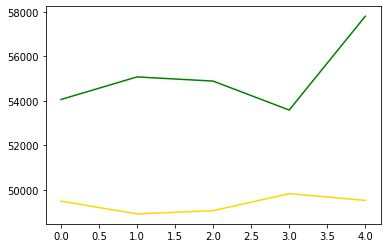

In [13]:
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')

In [14]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

5917.517107050635


큰 트렌드조차 예측할수 없을 정도로 현 코인의 시세변동은 매우 불안정하다.

## 2. Facebook Prophet 분석

Prophet은 Additive 모델이라는 모델링 방법에 기반한 시계열 예측 모델.  
데이터의 트렌드성(연간/월간/일간)을 예측하는 것에 초점이 맞추어져 있다.

In [15]:
from fbprophet import Prophet

In [16]:
# prophet을 사용하기 위해 feature 명을 변경
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

In [17]:
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

/Users/jeongjae/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [18]:
# 5일 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
361,2021-04-27,44693.376725,43013.391874,46451.597055
362,2021-04-28,42193.553475,40434.709988,43997.940713
363,2021-04-29,39780.145500,38187.432663,41610.965276
364,2021-04-30,37105.734310,35401.401789,38785.236547
365,2021-05-01,34631.808613,32864.995507,36487.466510


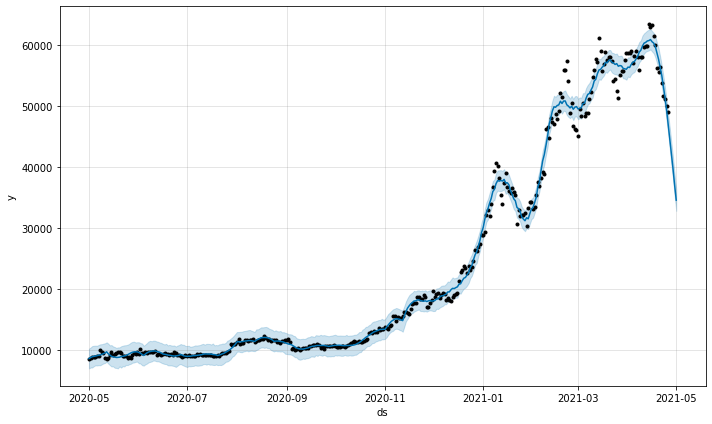

In [19]:
fig1 = prophet.plot(forecast_data)

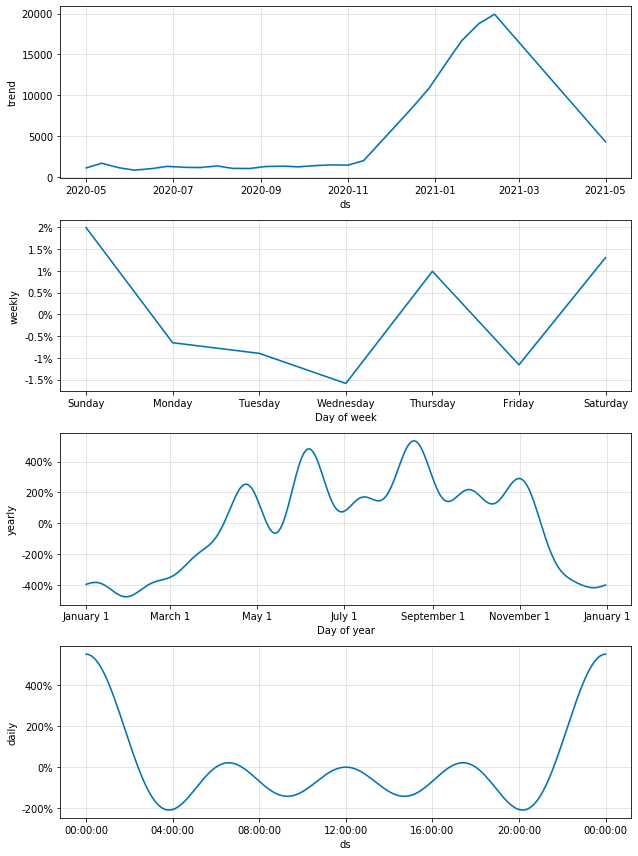

In [20]:
fig2 = prophet.plot_components(forecast_data)

In [21]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 5일 예측 데이터
pred_y = forecast_data.yhat.values[-5:]
test_t = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

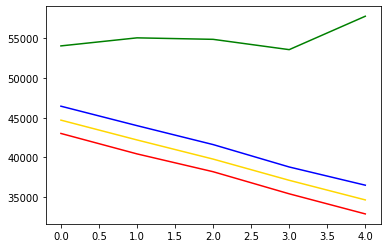

In [22]:
# 모델 그래프 시각화
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')
plt.plot(pred_y_lower, color='red')
plt.plot(pred_y_upper, color='blue')

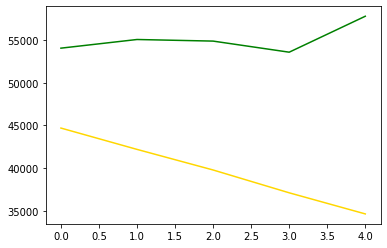

In [23]:
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')

In [24]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

16061.054059053062


rmse 값의 비교를 했을때 arima의 성능이 더 좋다.

## 성능 향상을 위한 방법

### 1. 상한값 혹은 하한값을 지정해준다.

In [25]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한값 설정
bitcoin_df['cap'] = 70000

# 상한값 적용을 위한 파라미터 설정
prophet = Prophet(seasonality_mode='multiplicative',
                 growth='logistic', # 기존과 다른 변경사항
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

/Users/jeongjae/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


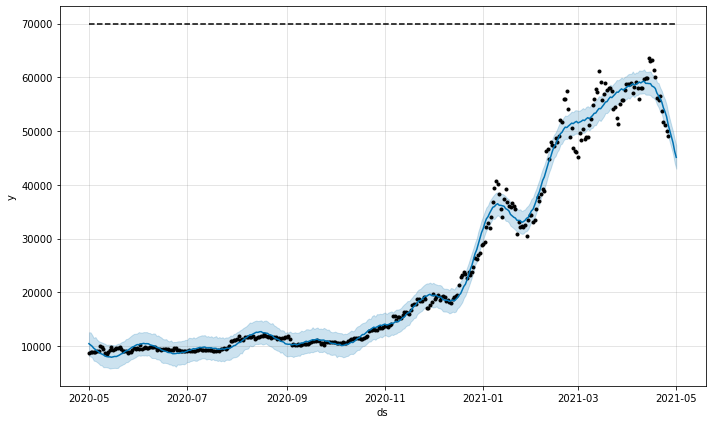

In [26]:
# 5일 예측
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가 설정
future_data['cap'] = 70000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

In [27]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 5일 예측 데이터
pred_y = forecast_data.yhat.values[-5:]
test_t = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

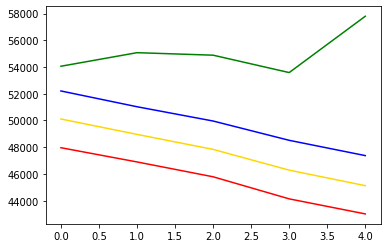

In [28]:
# 모델 그래프 시각화
plt.plot(pred_y, color='gold')
plt.plot(test_y, color='green')
plt.plot(pred_y_lower, color='red')
plt.plot(pred_y_upper, color='blue')

In [29]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

7954.607664129023


상한값을 설정하기 전보다 예측 성능이 향상되었다